With this code, you will:
1) Transform your raw fiber photometry data from TDT's proprietary file format into python-readable streams
2) Visualize raw data, and easily extract time stamps (in seconds) for events (ex: TTL pulses) that are visible in your photometry file
3) Correct photometry traces for motion (using linear regression to compare isosbestic/motion and gcamp/sensor channels), and optionally smooth the resulting traces
4) Read in manually scored behavior data, aligning behavior events of interest to photometry data
5) Extract only points of time of interest in photometry trace (ex: parts of trace associated with a specific behavior event) and generate a csv output file for further analysis
6) Preview points of interest in a single PSTH format plot, as a preview for your csv output file
7) *Additional cells to analyze behavior/sensor expressoin will continue to be added

In [55]:
#INSTALL TDT
!pip install tdt #If you acquired photometry data using TDT systems
# LOAD DATA AND LIBRARIES
import tdt
from tdt import read_block, epoc_filter
import matplotlib.pyplot as plt #python libraries to read and visualize data
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta
import csv
from scipy.stats import sem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [56]:
#MOUNT GOOGLE DRIVE
#if your datasets are not stored in gdrive, skip this
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [57]:
#LOAD PHOTOMETRY AND BEHAVIOR DATA, READ TDT FILE TYPE INTO PYTHON FORMAT
mouse = '002v' #enter: subject number + experimenter first initial
experiment = 'Pre'#enter: 'Pre', 'Post' or 'Ctrl'
date = '20230622'#enter: data acquisition date
PATH = 'gdrive/MyDrive/HabonJackie/GRAB2.0/' + mouse + '/' #enter: path to data location
sensorType='GRABda'#enter: subject's sensor
photometry = read_block(PATH + mouse + experiment + date)

read from t=0s to t=642.83s


In [58]:
#CREATE VARIABLES FROM PHOTOMETRY DATA
#Specify gcamp and time by sampling rate
num_gcamp_samples = len(photometry.streams.Dv1S.data)
gcamp_time = np.linspace(1, num_gcamp_samples, num_gcamp_samples) / photometry.streams.Dv1S.fs
gcamp = photometry.streams.Dv1S.data
#Specify isosbestic and time by sampling rate
num_iso_samples = len(photometry.streams.Dv2S.data)
iso_time = np.linspace(1, num_iso_samples, num_iso_samples) / photometry.streams.Dv2S.fs
iso = photometry.streams.Dv2S.data
#check that they line up
time = []
if iso_time.all() == gcamp_time.all():
    for i in range(0,len(iso_time)):
        time.append(iso_time[i])
else:
    print("TIMES NOT EQUAL")

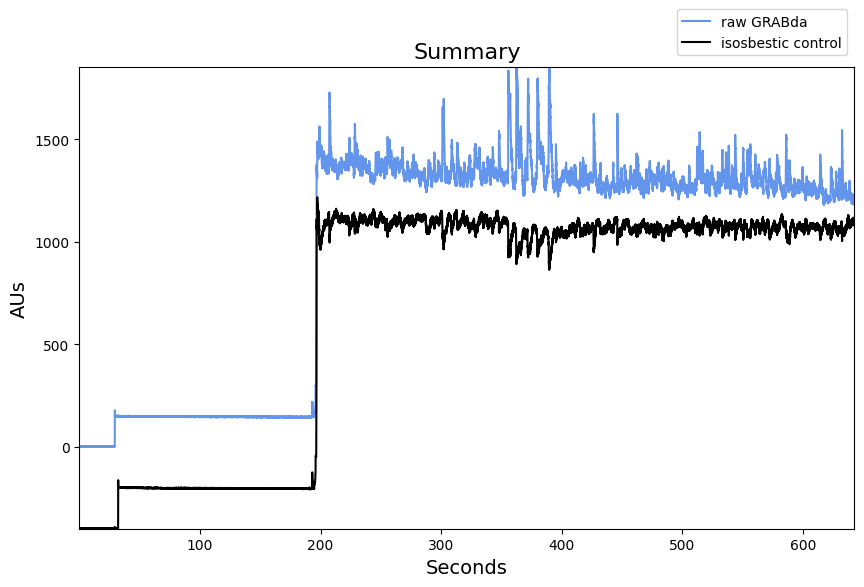

In [63]:
# PLOT SUMMARY OF RAW PHOTOMETRY DATA

# declare the figure size
fig1 = plt.subplots(figsize=(10, 6))


# plot the line using slices
plt.plot(time,gcamp, color='cornflowerblue')
plt.plot(time,iso, color = 'k')

# create title, axis labels, and legend
plt.title('Summary', fontsize=16)
plt.xlabel('Seconds', fontsize=14)
plt.ylabel('AUs', fontsize=14)
plt.legend(('raw '+sensorType,'isosbestic control'),
           loc='lower right',
           bbox_to_anchor=(1.0,1.01)
          )
plt.autoscale(tight=True)

#plt.vlines(x=times[1]/sampling_rate, ymin = -50, ymax = 300, lw=2, color='k', ls ='--')

In [62]:
#IF ISO CHANNEL IS NOT CONSISTENTLY < GCAMP, APPLY A CORRECITON
iso_correction = 200
iso = iso - iso_correction
#run the cell above again to double-check that correction was sufficient

In [64]:
#FIND TIMESTAMP TO SYNCHRONIZE YOUR PHOTOMETRY DATA TO BEHAVIOR DATA
sampling_rate = 1017 #this is given, but should be checked sometimes w/ experimenter
#next two lines should flank the point of time of your synchronizing event (TTL or not)
startTime = 0 #enter: a time just before your synchronizer (as seen in plot above)
endTime = 100 #enter: a time just after your synchronizer (as seen in plot above)
syncTime = [] #within the specified range, we look for a large jump in signal (light on)
for i in range(startTime*sampling_rate,endTime*sampling_rate):
    if gcamp[i] >= (gcamp[i-(int(sampling_rate))] + 100):
      syncTime = i/sampling_rate
      break

In [65]:
#OPTIONAL: FIND PLUGIN EXPRESSION VALUE
import math
plugTime = []
postSync = math.ceil(syncTime*sampling_rate)
for i in range(postSync,len(gcamp)): #in the time after you turn the light on
    if gcamp[i] >= (gcamp[math.ceil(syncTime)*sampling_rate]+ 200): #if theres another expression jump of 200
      plugTime = i/sampling_rate #that's the plugin time
      break
expTime = plugTime + 60 #this is the time we're interested in post initial bleaching for expression

In [66]:
#OPTIONAL: CALCULATE DELTA FOR EXPRESSION (ie subject's expression - light on expression)
window = 10*sampling_rate
expVal = np.mean(gcamp[math.ceil(expTime-50)*sampling_rate-window:math.ceil(expTime)*sampling_rate+window])
syncVal = gcamp[(math.ceil(syncTime+3)*sampling_rate)]

expVal-syncVal

1233.83

In [67]:
# CREATE VARIABLES FROM BEHAVIOR DATA
# This reads in your behavior annotation, and using sync it aligns it to your photometry data
behavior_filename = PATH + mouse + experiment + date + '.csv' #DIY: path to behavior file
infile = open(behavior_filename, 'r')

lines = infile.readlines()

behavior = []
#for line in lines[1:]: #skip the first line, which is the header
#for i in range(0,len(lines)):
for line in lines[1:]:
     sline = line.strip() #get rid of trailing newline characters at the end of the line
     sline = sline.split(',')  # separates line into a list of items.  ',' tells it to split the lines at the commas
        #colonyCount = int(sline[1]) #store the colony count for the line as an integer
     temp = sline[0:5]
     behavior.append(temp)
#close the file
infile.close()

#behavior #to see file

In [68]:
#CONVERT BEHAVIOR .CSV TIMES INTO READABLE TIMES
convertTimes = []
for i in range(0,len(behavior)):
  convertTimes.append(datetime.strptime(behavior[i][1],"%H:%M:%S"))

In [73]:
#FILTER TO BEHAVIORS OF INTEREST AND SYNCHRONIZE TO PHOTOMETRY TRACE

#convert the behavior table to a dataframe
#split by behavior
df = pd.DataFrame(behavior, columns=['Individual', 'VidEvents', 'Type','Trial','Notes?'])
#df #to see the table

#Specify any behaviors of interest within data file
column_condition1 = df['Type'] == 'VidSyncTime'
column_condition2 = df['Type'] == 'RetrievalOnset'

# Filter the DataFrame based on the condition
filtered_df = df[column_condition1 | column_condition2]

#Synchronize to photometry trace
secondsIn = []
for i in range(1,len(filtered_df)):
  secondsIn.append((convertTimes[i]-convertTimes[0]).seconds)

In [74]:
#OPTIONAL: CALCULATE RETRIEVAL LATENCIES (SKIPPING TRIAL 0-1)
Avg_retrieval = (secondsIn[-1]-secondsIn[0])/4
Avg_retrieval

8.25

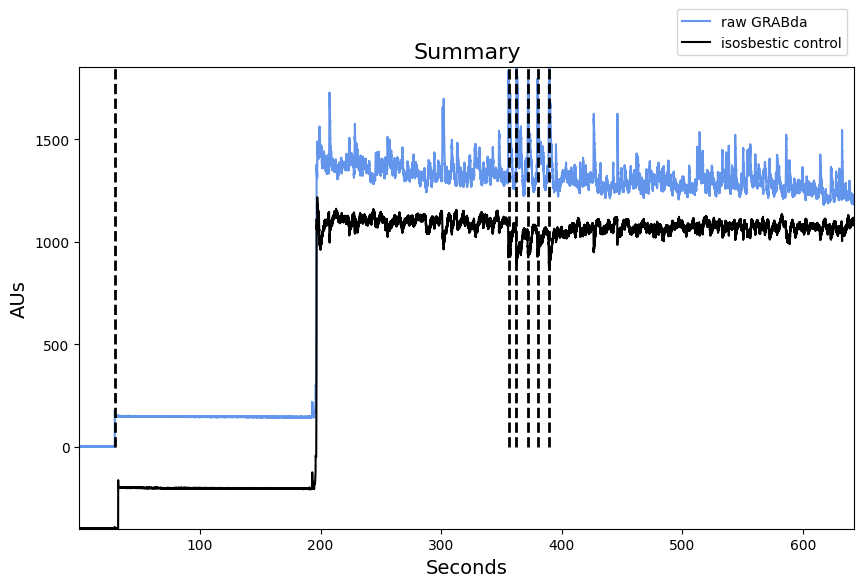

In [75]:
# PLOT UPDATED SUMMARY OF PHOTOMETRY DATA
# This will now show a black dotted line for sync event + all behavior events (retrievals) of interest
# Blue lines are for your optional expresson checks

# declare the figure size
fig1 = plt.subplots(figsize=(10, 6))


# plot the line using slices
plt.plot(time,gcamp, color='cornflowerblue')
plt.plot(time,iso, color = 'k')

# create title, axis labels, and legend
plt.title('Summary', fontsize=16)
plt.xlabel('Seconds', fontsize=14)
plt.ylabel('AUs', fontsize=14)
plt.legend(('raw '+sensorType,'isosbestic control'),
           loc='lower right',
           bbox_to_anchor=(1.0,1.01)
          )
plt.autoscale(tight=True)

plt.vlines(x=syncTime , ymin = 0, ymax = max(gcamp), lw=2, color='k', ls ='--')
#OPTIONAL plt.vlines(x=plugTime, ymin = 0, ymax = max(gcamp), lw=2, color='blue', ls ='--')
#OPTIONAL plt.vlines(x=expTime -40, ymin = 0, ymax = max(gcamp), lw=2, color='blue', ls ='--')

for i in range(0,len(secondsIn)):
    #if behaviorTable[i][3] == eventType:
  plt.vlines(x=secondsIn[i] +syncTime, ymin = 0, ymax = max(gcamp), lw=2, color='k', ls ='--')


In [76]:
# LINEAR REGRESSION TO FIT GCAMP CHANNEL TO ISO/MOTION ARTIFACT CHANNEL
X = gcamp.reshape(-1, 1)
Y = iso.reshape(-1,1)
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(Y)  # make predictions
signal = X - Y_pred
#Credit: https://towardsdatascience.com/linear-regression-in-6-lines-of-python-5e1d0cd05b8d

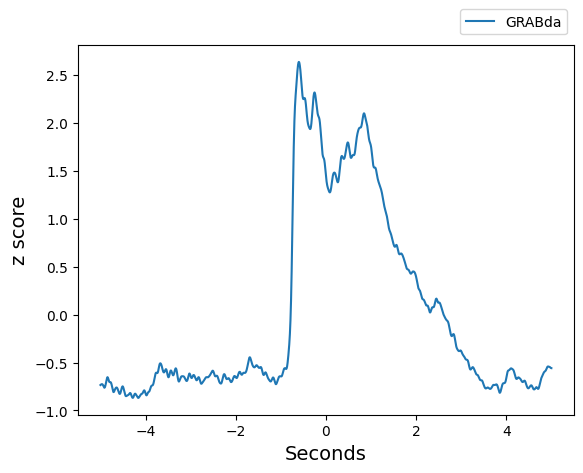

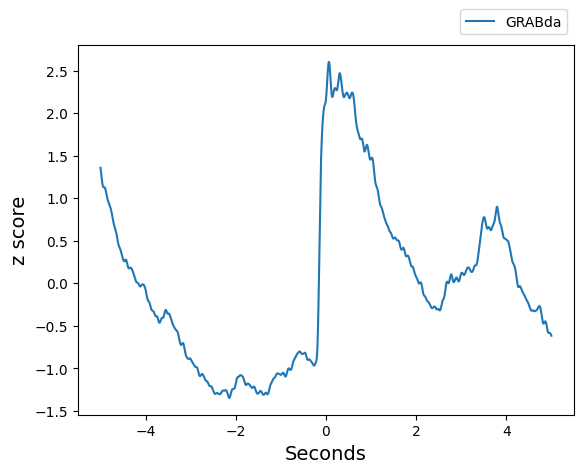

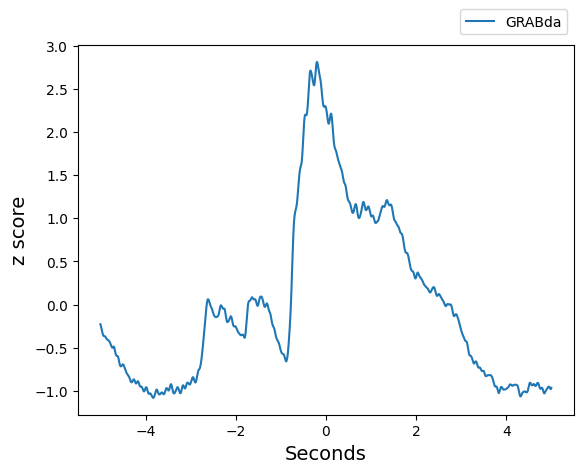

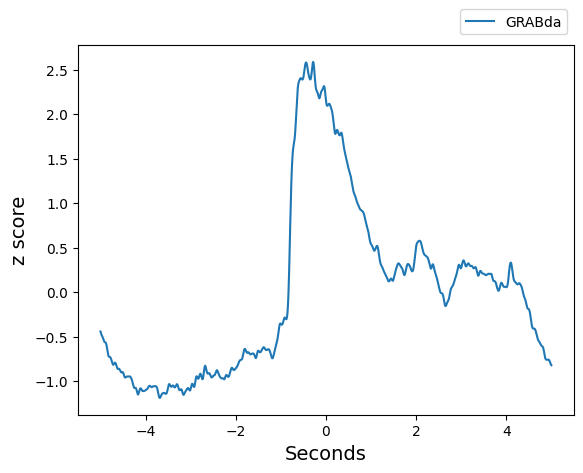

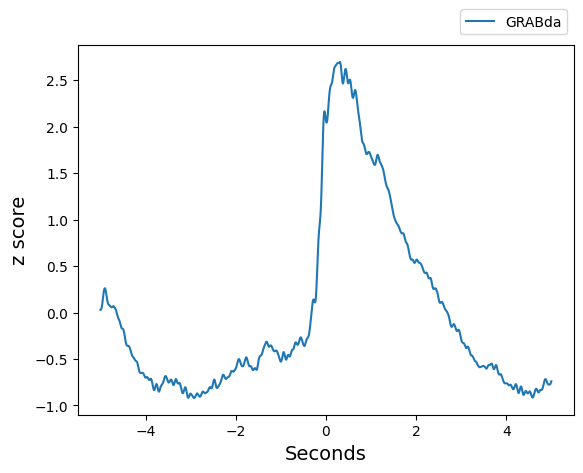

In [82]:
# NOW PLOT INDIVIDUAL EVENTS AND GENERATE AN OUTPUT FILE FOR THEM WITH SYNCED BEHAVIOR
from scipy import stats
outputFile = []
time = np.array(time)
offset = 5 #seconds

for i in range(0, len(behavior)-1):
    indices = np.argwhere(((np.array(time)>=(secondsIn[i]+syncTime)-offset))&(np.array(time)<((secondsIn[i]+syncTime)+offset)))[0:]
    windowT = time[int(indices[0]):int(indices[-1])]
    windowS = signal[int(indices[0]):int(indices[-1])]
    zscore = stats.zscore(windowS)
    outputFile.append(zscore)
    plt.figure()
    plt.plot(np.linspace(-offset,offset,len(windowS)),zscore) #can do windowT to double check
    # create title, axis labels, and legend
    #plt.title((eventType,i+1), fontsize=16)
    plt.xlabel('Seconds', fontsize=14)
    plt.ylabel('z score', fontsize=14)
    plt.legend((sensorType,),
           loc='lower right',
           bbox_to_anchor=(1.0,1.01)
          )

In [79]:
# CREATE OUTPUT FILE
transposed_list = list(zip(*outputFile))
transposed_list = pd.DataFrame(transposed_list, columns=['Trial1', 'Trial2','Trial3','Trial4','Trial5'])

# Specify the window size for the rolling average
smoothingFactor = 2000 #OPTIONAL DIY: extent of rolling average

# Calculate the rolling average for each column
rollingAvg = transposed_list.rolling(window=smoothingFactor, min_periods=1).mean()

# Specify the file path for the CSV file
file_path = PATH + mouse+experiment+date+"."+str(smoothingFactor)+'X.Output.csv'

# Write the DataFrame to CSV
rollingAvg.to_csv(file_path, index=False)

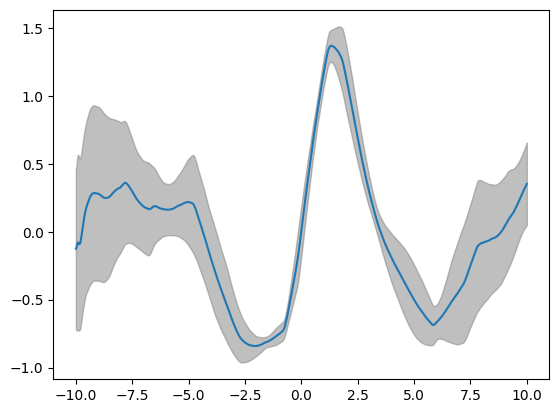

In [80]:
#CREATE PSTH AS PREVIEW TO WHAT PLOT WILL LOOK LIKE WITH YOUR OUTPUT COLUMNS
fT = np.arange(-10,10,(offset*2/len(windowS))) #time made for plot
plt.plot(fT,np.mean(rollingAvg,1))
ysem = rollingAvg.sem(axis=1)
ymean = rollingAvg.mean(axis=1)
plt.fill_between(fT,ymean-ysem,ymean+ysem,color='grey',alpha=0.5,label='sem')

In [81]:
#OPTIONAL: quantificaiton of before vs during event neural signal
pre_pup = (ymean[9*sampling_rate] + ymean[8*sampling_rate])/2
during_pup = (ymean[10*sampling_rate] + ymean[11*sampling_rate])/2
print("pre pup is:" + str(pre_pup) + "during pup is:" + str(during_pup))

pre pup is:-0.7981501126730539during pup is:0.5910140716920905


In [ ]:
#Make a timme variable to plot in other softwares (rarely do this)
#import pandas as pd
#import numpy as np

#start = -10
#end = 10
#interval = 1/20344*20

#data = np.arange(start, end + interval, interval)
#df = pd.DataFrame(data, columns=['Numbers'])

#print(df)

# Specify the file path for the CSV file
#file_path = PATH +'TimeVar.csv'

# Write the DataFrame to CSV
#df.to_csv(file_path, index=False)